# Create a Lightcurve Simulator in Gammapy-0.20

## 0 - Setup: import packages of the environment gammapy-0.20

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy.table import Table
from astropy.io import fits

import logging
log = logging.getLogger(__name__)

In [2]:
from gammapy.data import Observation
from gammapy.data import observatory_locations
from gammapy.datasets import SpectrumDataset, Datasets, FluxPointsDataset
from gammapy.estimators import LightCurveEstimator
from gammapy.irf import (
    load_cta_irfs,
    EffectiveAreaTable2D,
    Background2D, Background3D,
    EnergyDispersion2D, EDispKernel,
    FoVAlignment
)
from gammapy.makers import SpectrumDatasetMaker
from gammapy.maps import MapAxis, RegionGeom, TimeMapAxis
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    ExpDecayTemporalModel,
    SkyModel,
    ExpCutoffPowerLaw3FGLSpectralModel
)

In [3]:
TimeMapAxis.time_format = "iso" # Define preferred time format

## 1 - Define Geometry, Pointing and Temporal information

In [4]:
# Define Data Directory
input_directory = "/home/gabriele/Documents/mydata/xspec_GBM_GRB120323A/"

In [5]:
# Load a file that contains information about the position
file_pha = input_directory + 'GRB120323A_b0.pha'

hdul_pha = fits.open(file_pha)

hdul_pha[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
CREATOR = 'GBM Data Tools 1.1.0 Software and version creating file'             
FILETYPE= 'SPECTRUM'           / Name for this type of FITS file                
FILE-VER= '1.0.0   '           / Version of the format for this filetype        
TELESCOP= 'GLAST   '           / Name of mission/satellite                      
INSTRUME= 'GBM     '           / Specific instrument used for observation       
DETNAM  = 'BGO_00  '           / Individual detector name                       
OBSERVER= 'Meegan  '           / GLAST Burst Monitor P.I.                       
ORIGIN  = 'GIOC    '           / Name of organization making file               
DATE    = '2022-04-26T12:32:

In [6]:
# Reference Time of the simulated observations
ref_t0 = Time("2012-03-23T12:10:19")  

# Pointing Direction of the simulated instrument
pointing = SkyCoord(30.0, -15.0, unit="deg", frame="fk5")

In [7]:
# Create Instrument FoV_lon axis
axis_fovlon = MapAxis.from_bounds(-1.0, 1.0, unit="degree", nbin=1, name="fov_lon")

# Print
print(axis_fovlon)
axis_fovlon.as_plot_labels

MapAxis

	name       : fov_lon   
	unit       : 'deg'     
	nbins      : 1         
	node type  : edges     
	edges min  : -1.0e+00 deg
	edges max  : 1.0e+00 deg
	interp     : lin       



['-1.00e+00 deg - 1.00e+00 deg']

In [8]:
# Create Instrument FoV_lat axis
axis_fovlat = MapAxis.from_bounds(-1.0, 1.0, unit="degree", nbin=1, name="fov_lat")

# Print
print(axis_fovlat)
axis_fovlat.as_plot_labels

MapAxis

	name       : fov_lat   
	unit       : 'deg'     
	nbins      : 1         
	node type  : edges     
	edges min  : -1.0e+00 deg
	edges max  : 1.0e+00 deg
	interp     : lin       



['-1.00e+00 deg - 1.00e+00 deg']

In [9]:
# Create Offset axis
axis_offset = MapAxis.from_bounds(0.0, 1.0, unit="degree", nbin=1, name="offset")

# Print
print(axis_offset)
axis_offset.as_plot_labels

MapAxis

	name       : offset    
	unit       : 'deg'     
	nbins      : 1         
	node type  : edges     
	edges min  : 0.0e+00 deg
	edges max  : 1.0e+00 deg
	interp     : lin       



['0.00e+00 deg - 1.00e+00 deg']

## 2 - Define Energy Axes and IRFs
Effective Area, Spectral Background model, Energy Dispersion Matrix 

In [10]:
file_arf = input_directory+'GRB120323A_b0.arf'
file_bak = input_directory+'GRB120323A_b0.bak'

hdul_arf = fits.open(file_arf)
hdul_bak = fits.open(file_bak)

In [11]:
# Explore FITS file to get the correct headers and column names and units.
print("Effective Area:\n")
print(hdul_arf.info())
print(hdul_arf[1].columns)

print("\n\nBackground Spectral model:\n")
print(hdul_bak.info())
print(hdul_bak[1].columns)
print(hdul_bak[2].columns)

Effective Area:

Filename: /home/gabriele/Documents/mydata/xspec_GBM_GRB120323A/GRB120323A_b0.arf
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  SPECRESP      1 BinTableHDU     28   140R x 3C   [E, E, E]   
None
ColDefs(
    name = 'ENERG_LO'; format = 'E'; unit = 'keV'
    name = 'ENERG_HI'; format = 'E'; unit = 'keV'
    name = 'SPECRESP'; format = 'E'; unit = 'cm**2'
)


Background Spectral model:

Filename: /home/gabriele/Documents/mydata/xspec_GBM_GRB120323A/GRB120323A_b0.bak
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      32   ()      
  1  EBOUNDS       1 BinTableHDU     49   128R x 3C   [I, E, E]   
  2  SPECTRUM      1 BinTableHDU     60   128R x 3C   [I, D, D]   
  3  GTI           1 BinTableHDU     40   1R x 2C   [D, D]   
None
ColDefs(
    name = 'CHANNEL'; format = 'I'
    name = 'E_MIN'; format = 'E'
    name = 'E_MAX'; format = 'E'
)
ColDefs(
    name

In [12]:
# Data & Names relatives to Effective Area
name_arf_HDU = 'SPECRESP' # Name of the HDU that contains effective area
name_arf_LoE = 'ENERG_LO' # Name of the Low-edge column of energy bin in name_arf_HDU
name_arf_HiE = 'ENERG_HI' # Name of the High-edge column of energy bin in name_arf_HDU
unit_E   = u.keV
unit_aef = u.cm**2

# Data & Names relatives to Background Spectral Model
dict_bak = {'CHANNEL' :hdul_bak['EBOUNDS' ].data['CHANNEL'],
            'E_MIN'   :hdul_bak['EBOUNDS' ].data['E_MIN'],
            'E_MAX'   :hdul_bak['EBOUNDS' ].data['E_MAX'],
            'RATE'    :hdul_bak['SPECTRUM'].data['RATE'],
            'STAT_ERR':hdul_bak['SPECTRUM'].data['STAT_ERR']}
unit_bkg = (u.keV*u.s*u.sr)**(-1)

#### Create True Energy Axis from the .arf (Effective Area file). It is going to be used by Aeff and Edisp.

In [13]:
# Store relevant quantities in a DataFrame and exclude some energy bins
DaFr_arf = pd.DataFrame(hdul_arf[name_arf_HDU].data)[1:-1]

DaFr_arf

,ENERG_LO,ENERG_HI,SPECRESP
1,105.579002,111.470001,32.306133
2,111.470001,117.689003,51.826759
3,117.689003,124.254997,71.884880
4,124.254997,131.188004,91.076569
5,131.188004,138.507004,106.474533
...,...,...,...
134,144397.000000,152453.000000,220.899979
135,152453.000000,160959.000000,212.975616
136,160959.000000,169939.000000,201.019135
137,169939.000000,179421.000000,189.152267


In [14]:
# Energy edges are taken from the lower edges column, plus the last of the higer edges to include the last bin.
energy_true_edges = (DaFr_arf[name_arf_LoE].tolist()+[DaFr_arf[name_arf_HiE].iloc[-1]]) * unit_E

# Define Energy True axis. Interpolation: 'log' is default, 'lin' used by keV instruments
axis_energy_true  = MapAxis.from_energy_edges(energy_true_edges,
                                              name = "energy_true",
                                              interp = 'lin' #'lin'
                                             )

# Print
print(axis_energy_true)
# axis_energy_true.as_plot_labels

MapAxis

	name       : energy_true
	unit       : 'keV'     
	nbins      : 138       
	node type  : edges     
	edges min  : 1.1e+02 keV
	edges max  : 1.9e+05 keV
	interp     : lin       



#### Create (Reco) Energy Axis from the .bak (Background Spectral model file). It is going to be used in Bkg and Edisp.

In [15]:
# Store relevant quantities in DataFrames and exclude some eneergy bins.
DaFr_bak = pd.DataFrame(dict_bak)[1:-1]

DaFr_bak

,CHANNEL,E_MIN,E_MAX,RATE,STAT_ERR
1,1,216.706970,250.773270,78.150694,0.539997
2,2,250.773270,284.649506,72.993404,0.533588
3,3,284.649506,318.347656,62.176809,0.527442
4,4,318.347656,351.879639,57.811752,0.524790
5,5,351.879639,385.257446,64.827815,0.529911
...,...,...,...,...,...
122,122,34198.585938,36027.074219,1.514420,0.486793
123,123,36027.074219,37989.234375,1.386072,0.486726
124,124,37989.234375,40107.546875,1.077159,0.486767
125,125,40107.546875,42526.738281,2.286869,0.486740


In [16]:
# Energy edges are taken from the lower edges column, plus the last of the higer edges to include the last bin.
energy_reco_edges = (DaFr_bak['E_MIN'].tolist()+[DaFr_bak['E_MAX'].iloc[-1]]) * unit_E

# Define (Reco )Energy axis. Interpolation: 'log' is default, 'lin' used by keV instruments
axis_energy_reco = MapAxis.from_energy_edges(energy_reco_edges,
                                             name = "energy",
                                             interp = 'lin' #'lin'
                                            )

# Print
print(axis_energy_reco)
# axis_energy_reco.as_plot_labels

MapAxis

	name       : energy    
	unit       : 'keV'     
	nbins      : 126       
	node type  : edges     
	edges min  : 2.2e+02 keV
	edges max  : 4.5e+04 keV
	interp     : lin       



#### Create Effective area object

EffectiveAreaTable2D
--------------------

  axes  : ['energy_true', 'offset']
  shape : (138, 1)
  ndim  : 2
  unit  : cm2
  dtype : float64



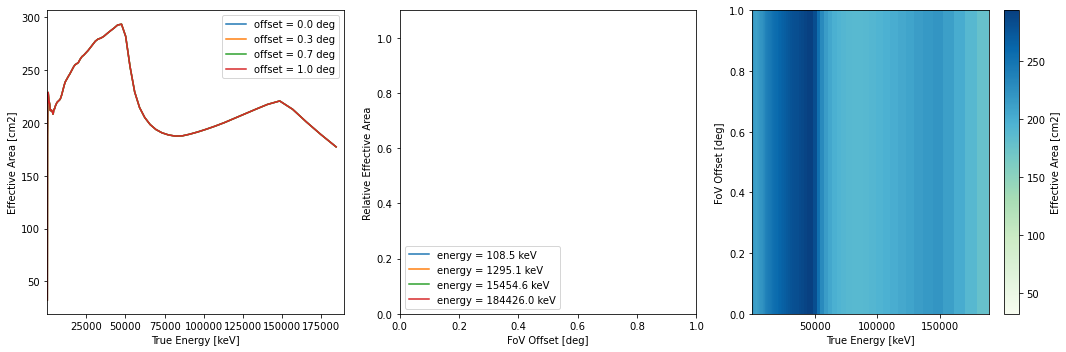

In [17]:
# Prepare Effective Area Matrix (as a function of energy and offset) as ndarray
data_arf = np.ndarray( (axis_energy_true.nbin, axis_offset.nbin) )

for i in range(axis_offset.nbin):
    data_arf.transpose()[i] = DaFr_arf[name_arf_HDU].to_numpy()

# Instantiate Effective Area object # I should add meta=metadata dictionary from header
aeff = EffectiveAreaTable2D(axes = [axis_energy_true, axis_offset],
                            data = data_arf,
                            unit = unit_aef
                           )

# Print
print(aeff)
aeff.peek()

#### Create Background spectral model object

Background3D
------------

  axes  : ['energy', 'fov_lon', 'fov_lat']
  shape : (126, 1, 1)
  ndim  : 3
  unit  : 1 / (keV s sr)
  dtype : float64



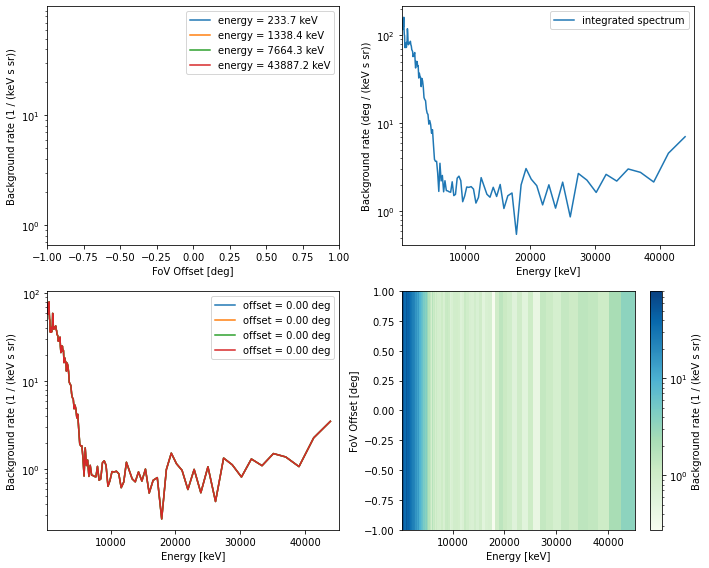

In [18]:
# Prepare Background Matrix (as a function of energy, lon and lat) as ndarray
data_bak = np.ndarray( (axis_energy_reco.nbin, axis_fovlon.nbin, axis_fovlat.nbin) )
for i in range(axis_fovlat.nbin):
    for j in range(axis_fovlon.nbin):
        data_bak.transpose()[i][j] = DaFr_bak['RATE'].to_numpy()

# Instantiate Background object # I should add meta=metadata dictionary from header    
bkg = Background3D(axes = [axis_energy_reco, axis_fovlon, axis_fovlat],
                   data = data_bak,
                   unit = unit_bkg,
                   #is_pointlike=False,
                   #fov_alignment=FoVAlignment.RADEC,
                   #meta=None,
                   #interp_kwargs=None
                   )

# Print
print(bkg)
bkg.peek()

#### Define a diagional Energy Dispersion Matrix

EnergyDispersion2D
------------------

  axes  : ['energy_true', 'migra', 'offset']
  shape : (138, 50, 1)
  ndim  : 3
  unit  : 
  dtype : float64



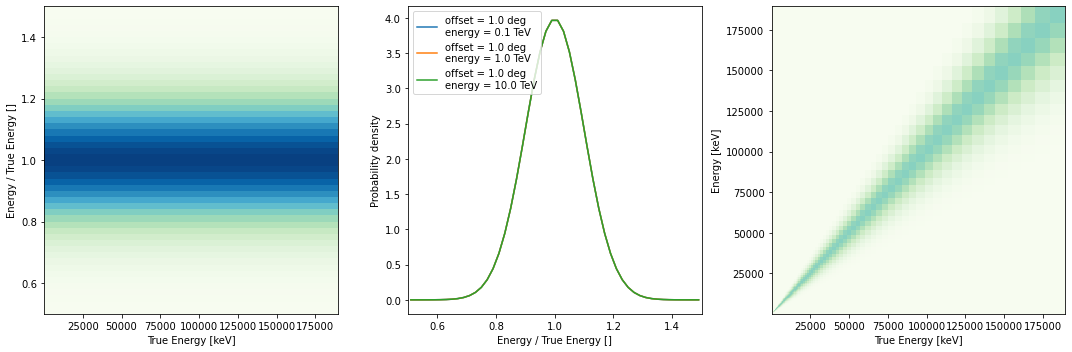

In [19]:
# Create Axis of Energy Migration
axis_energy_migr = MapAxis.from_bounds(0.5, 1.5, nbin=50, name="migra")

# Instantiate Energy Dispersion Matrix object # I should add meta=metadata dictionary from header
edisp = EnergyDispersion2D.from_gauss(energy_axis_true = axis_energy_true,
                                      migra_axis       = axis_energy_migr,
                                      offset_axis      = axis_offset,
                                      bias             = 0,
                                      sigma            = 0.1,
                                      # interp           = 'lin' # Gaussian is in log
                                     )

# Print
print(edisp)
edisp.peek()

#### Build IRFs object (dictionary)

In [20]:
IRFs = {'aeff': aeff,
        'bkg': bkg,
        'edisp': edisp
       }

### 3 - Define Temporal and Spectral Model for the simulated source

In [21]:
# Geometry object: a sky region covered by a pixel, with arbitrary shape and size
geom = RegionGeom.create("fk5;circle(30.0, -15.0, 0.11)", axes=[axis_energy_reco])

In [22]:
# Spectral model
spectral_model = ExpCutoffPowerLaw3FGLSpectralModel(
    index     = 1.48 * u.Unit(""),
    amplitude = "2.6e-1 cm-2 s-1 keV-1",
    reference = "100 keV",
    ecut      = 100.0*u.keV,
)

# Temporal model
temporal_model = ExpDecayTemporalModel(
    t0    = "2 h",
    t_ref = ref_t0.mjd * u.d
)

# Complete Source Model = Temporal & Spectral
model_simu = SkyModel(
    spectral_model = spectral_model,
    temporal_model = temporal_model,
    name           = "model-simu"
)

/home/gabriele/anaconda3/envs/gammapy-0.20/lib/python3.8/site-packages/astropy/units/quantity.py:613: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/gabriele/anaconda3/envs/gammapy-0.20/lib/python3.8/site-packages/astropy/units/quantity.py:613: RuntimeWarning: invalid value encountered in subtract
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


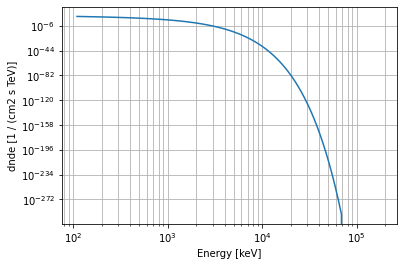

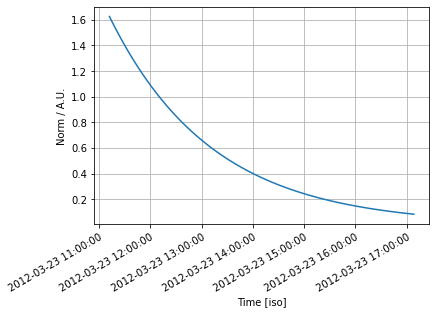

type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str9,float64,str14,int64,float64,float64,bool,bool,str1
spectral,index,1.4800e+00,,0.000e+00,nan,nan,False,False,
spectral,amplitude,2.6000e-01,cm-2 keV-1 s-1,0.000e+00,nan,nan,False,True,
spectral,reference,1.0000e+02,keV,0.000e+00,nan,nan,True,False,
spectral,ecut,1.0000e+02,keV,0.000e+00,nan,nan,False,False,
temporal,t0,2.0000e+00,h,0.000e+00,nan,nan,False,False,
temporal,t_ref,5.6010e+04,d,0.000e+00,nan,nan,True,False,


In [23]:
# Print
energy_bounds = [axis_energy_true.edges[0], axis_energy_true.edges[-1]]
spectral_model.plot(energy_bounds)
plt.grid(which="both")
plt.show()

time_range = [ref_t0-1.0*u.h, ref_t0 + 5.*u.h]
temporal_model.plot(time_range)
plt.grid(which="both")
plt.show()

model_simu.parameters.to_table()

### 4 - Define observation number, start and duration

In [24]:
n_obs = 30         # Number of observations = number of Flux points
live_t_obs = 10    # Time duration of each observation
dead_t_obs = 1     # Rest time between observations
unit_t_obs = u.min # Unit of measure of the time duration
t_first_ob = 0.0   # Starting time of the first observation wrt reference time

In [25]:
# Livetimes = Duration of the observations
livetimes = np.full(n_obs, live_t_obs).tolist()* unit_t_obs

# Starting Time of Each observation
t_stop = n_obs * (live_t_obs + dead_t_obs)
starting_times = np.linspace(t_first_ob, t_stop, num=n_obs, endpoint=False).tolist() * unit_t_obs

# Create SpectrumDataset object.
# This is used to pass Geometry and Energy information to each observation inside the loop
empty = SpectrumDataset.create(geom = geom,
                               energy_axis_true = axis_energy_true,
                               name ="empty")

# Create Maker object, that makes spectrum for a single IACT observation
# selection = creates the maps requested. The only one not added here is 'counts'
maker = SpectrumDatasetMaker(selection=["exposure", "background", "edisp"])

# Create Datasets object, a collection of n_obs Dataset
# that store the results of the simulated observation
datasets = Datasets()

In [26]:
%%time
for idx in range(n_obs):
    # Create an empty observation object with given Pointing, IRFs, ObservationTimes.
    obs = Observation.create(
        pointing      = pointing,
        livetime      = livetimes[idx],
        tstart        = starting_times[idx],
        irfs          = IRFs,
        reference_time= ref_t0,
        obs_id        = idx,
        #In gammapy-0.20 maybe we need 'location'
    )
    # Copy empty SpectrumDataset from above to pass Geometry and Energy Axis.
    empty_i = empty.copy(name=f"dataset-{idx}")
    
#     ###DEBUG # DA PASSARE A make_map_background_irf
#     #print(empty_i.counts.geom)
    
#     from gammapy.maps import Map
    
#     print(obs.fixed_pointing_info)
#     #print(obs.observation_time_duration)
#     #print(obs.bkg)
#     #print(geom)
#     #print(maker.background_oversampling)
#     #print(maker.use_region_center)
    
#     #print(obs)
#     #print(obs.fixed_pointing_info.time_ref)
#     print(geom.to_image().get_coord().skycoord)
#     print(obs.fixed_pointing_info)
    
    
#     from astropy.coordinates import SkyCoord
#     other=obs.fixed_pointing_info
#     print(other)
#     print(isinstance(other, SkyCoord))
    
    
    
    #print(geom.to_image().get_coord().skycoord.separation(obs.fixed_pointing_info))
    ###DEBUG
    
    # Define new MapDataset that stores the observation, from the empty_i reference Dataset
    dataset = maker.run(empty_i, obs)
    
    # The Dataset now contains Geometry, Energy, Pointing, IRFs and ObservationTimes.
    # We just need to add the source model.
    dataset.models = model_simu
    
    # Simulate fake counts for the current model and reduced IRFs.
    # This method overwrites the counts defined on the dataset object.
    dataset.fake()
    
    # Add this dataset to our collection.
    datasets.append(dataset)

CPU times: user 3.91 s, sys: 51.5 ms, total: 3.96 s
Wall time: 3.97 s


In [27]:
datasets.meta_table

NAME,TYPE,TELESCOP,OBS_ID,RA_PNT,DEC_PNT
,,,,deg,deg
str10,str15,str7,int64,float64,float64
dataset-0,SpectrumDataset,Unknown,0,29.999995260272033,-14.999999425230799
dataset-1,SpectrumDataset,Unknown,1,29.999995260272033,-14.999999425230799
dataset-2,SpectrumDataset,Unknown,2,29.999995260272033,-14.999999425230799
dataset-3,SpectrumDataset,Unknown,3,29.999995260272033,-14.999999425230799
dataset-4,SpectrumDataset,Unknown,4,29.999995260272033,-14.999999425230799
dataset-5,SpectrumDataset,Unknown,5,29.999995260272033,-14.999999425230799
...,...,...,...,...,...
dataset-24,SpectrumDataset,Unknown,24,29.999995260272033,-14.999999425230799


In [28]:
#show_columns = ['name','counts', 'background','excess','livetime','sqrt_ts','npred','exposure_max','counts_rate']
datasets.info_table()#[0:4]
#datasets.info_table()[show_columns]#[1:4]

name,counts,excess,sqrt_ts,background,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,
str10,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str4,float64
dataset-0,199097,197892.890625,1279.9252854723272,1204.11279296875,1204.1126695871353,1204.11279296875,nan,1.9383679628372192,17.617753982543945,600.0,600.0,331.8283333333333,2.0068546549479165,329.821484375,126,126,cash,nan
dataset-1,180934,179729.88732799032,1205.9699634457409,1204.112672009674,181708.3399922873,1204.112672009674,180504.22732027766,1.9383679962158205,17.617754516601565,600.0,600.0,301.5566666666667,2.006854453349457,299.5498122133172,126,126,cash,-3348509.797550729
dataset-2,165362,164157.88732799032,1140.0167047515035,1204.112672009674,165897.83668486186,1204.112672009674,164693.72401285224,1.9383679962158205,17.617754516601565,600.0,600.0,275.60333333333335,2.006854453349457,273.59647887998386,126,126,cash,-3029349.3951183134
dataset-3,151109,149904.88732799032,1077.3048439281456,1204.112672009674,151472.1874528517,1204.112672009674,150268.07478084203,1.9383679962158205,17.617754516601565,600.0,600.0,251.84833333333333,2.006854453349457,249.84147887998387,126,126,cash,-2740096.2849900806
dataset-4,138091,136886.88732799032,1017.8055857581194,1204.112672009674,138310.0918687555,1204.112672009674,137105.97919674581,1.9383679962158205,17.617754516601565,600.0,600.0,230.15166666666667,2.006854453349457,228.1448122133172,126,126,cash,-2476921.904082176
dataset-5,126755,125550.88732799032,964.0388363200606,1204.112672009674,126300.87430227878,1204.112672009674,125096.76163026909,1.9383679962158205,17.617754516601565,600.0,600.0,211.25833333333333,2.006854453349457,209.25147887998386,126,126,cash,-2250863.8930324726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
dataset-24,23279,22074.887327990327,306.179876521577,1204.112672009674,23124.581811993212,1204.112672009674,21920.469139983543,1.9383679962158205,17.617754516601565,600.0,600.0,38.79833333333333,2.006854453349457,36.79147887998388,126,126,cash,-322629.00315240404


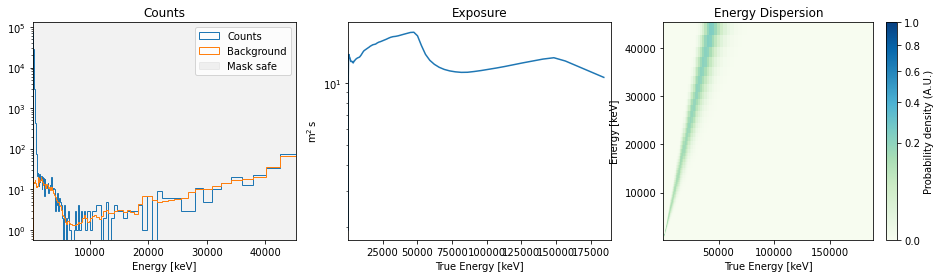

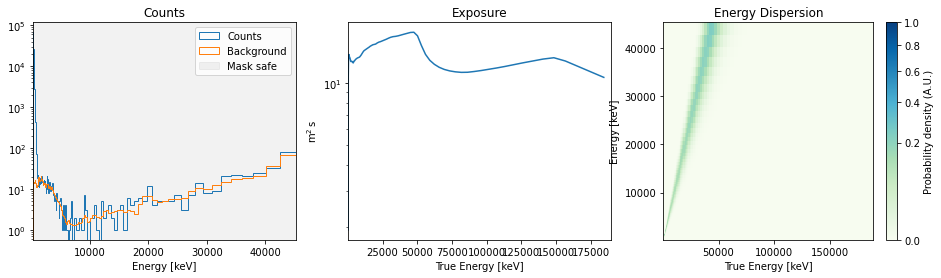

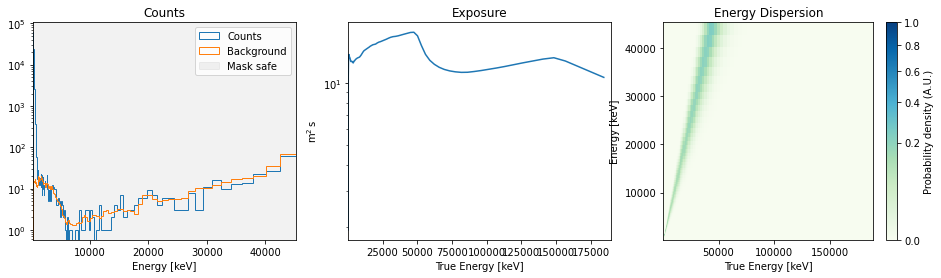

In [29]:
datasets[0].peek()
plt.show()
datasets[1].peek()
plt.show()
datasets[2].peek()
plt.show()

In [30]:
# Drop the Temporal Model, attach only the Spectral Model to all SpectrumDataset objects
datasets.models = SkyModel(spectral_model=spectral_model, name="model-fit")
datasets.models.to_parameters_table()

model,type,name,value,unit,error,min,max,frozen,is_norm,link
str9,str8,str9,float64,str14,int64,float64,float64,bool,bool,str1
model-fit,spectral,index,1.4800e+00,,0.000e+00,nan,nan,False,False,
model-fit,spectral,amplitude,2.6000e-01,cm-2 keV-1 s-1,0.000e+00,nan,nan,False,True,
model-fit,spectral,reference,1.0000e+02,keV,0.000e+00,nan,nan,True,False,
model-fit,spectral,ecut,1.0000e+02,keV,0.000e+00,nan,nan,False,False,


In [31]:
# Estimate a Flux Points light curve, each point is the flux of an observation
# The estimator fits the norm of the source model component to datasets in each time interval GTI.
#%%time
lc_maker_1d = LightCurveEstimator(energy_edges = [axis_energy_true.edges[0], axis_energy_true.edges[-1]],#OR RECO?
                                  source = "model-fit",
                                  selection_optional = ["ul"]
                                 )
# "all": all the optional steps are executed
# "errn-errp": estimate asymmetric errors.
# "ul": estimate upper limits.
# "scan": estimate fit statistic profiles.

lc_1d = lc_maker_1d.run(datasets)

(15422.465497685185, 15422.757164351851)

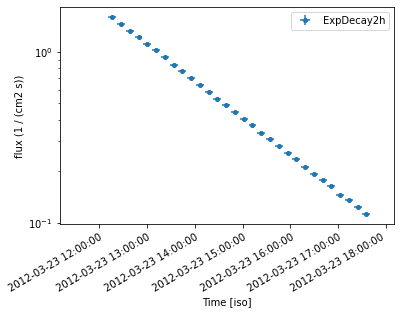

In [32]:
ax = lc_1d.plot(sed_type="flux",# "dnde", “flux”, “eflux”, “e2dnde”}
                #energy_power=1.0#Power of energy to multiply flux axis with
                marker="o",
                label="ExpDecay2h")

pl_start = ref_t0 - 1.*u.h
pl_end   = ref_t0 + 6.*u.h
ax.set_xlim(pl_start.plot_date,pl_end.plot_date)
